In [1]:
from pathlib import Path
from glob import glob

In [2]:
import numpy as np
import pandas as pd

import datasets
import neurokit2 as nk

In [3]:
from tqdm import tqdm

In [4]:
import collections

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
files = [file for file in glob('./data/ecg_preprocessed/*.csv')]

In [7]:
root = pd.read_csv(files[0])
root.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_18364\3008719704.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  root = pd.read_csv(files[0])


,timestamp,signal,signal_normalised,subject_id,category,code,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,...,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,2017-12-15 10:16:06+00:00,-0.000073,0.493088,30100,NaN,NaN,-0.000073,-0.000095,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,2017-12-15 10:16:06.001000+00:00,-0.000083,0.492200,30100,NaN,NaN,-0.000083,-0.000097,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,2017-12-15 10:16:06.002000+00:00,-0.000095,0.491090,30100,NaN,NaN,-0.000095,-0.000100,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,2017-12-15 10:16:06.003000+00:00,-0.000103,0.490368,30100,NaN,NaN,-0.000103,-0.000102,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,2017-12-15 10:16:06.004000+00:00,-0.000110,0.489757,30100,NaN,NaN,-0.000110,-0.000105,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [8]:
baseline = ['Sitting', 'Recov1', 'Recov2', 'Recov3', 'Recov4', 'Recov5', 'Recov6']
mental_stress = ['TA', 'SSST_Sing_countdown', 'Pasat', 'Raven', 'TA_repeat', 'Pasat_repeat']
high_physical_stress = ['Treadmill1', 'Treadmill2', 'Treadmill3', 'Treadmill4', 'Walking_fast_pace', 'Cycling', 'stairs_up_and_down']
moderate_physical_stress = ['Walking_own_pace', 'Dishes', 'Vacuum']
low_physical_stress = ['Standing', 'Lying_supine', 'Recov_standing']

def encode(label):
    if label in baseline:
        return 0
    elif label in mental_stress:
        return 1
    elif label in high_physical_stress:
        return 2
    elif label in moderate_physical_stress:
        return 3
    elif label in low_physical_stress:
        return 4
    else:
        return -1

In [9]:
sampling_rate = 1000
second = sampling_rate
minute = 60 * second

In [10]:
window_size = 1 * minute
window_shift_size = 0.25
step_size = int(window_shift_size * sampling_rate)

delineation, _ = nk.ecg_delineate(root['ECG_Clean'], sampling_rate=sampling_rate, method='peaks') 

data = []
with tqdm(total=len(root)) as pbar:
    for start_idx in range(0, len(root), step_size):
        pbar.set_description(f"Processing {start_idx}/{len(root)}")
        sample = root.iloc[start_idx:start_idx + window_size]

        rpeaks = sample[sample['ECG_R_Peaks'] == 1].index
        tpeaks = delineation[delineation['ECG_T_Peaks'] == 1].index

        label = collections.Counter(sample['category']).most_common(1)[0][0]

        data.append({
            'label': label,
            'category': encode(label),
            # **nk.hrv(rpeaks, sampling_rate=sampling_rate).iloc[0].to_dict(),
            **nk.hrv_time(rpeaks, sampling_rate=sampling_rate).iloc[0].to_dict(),
            **nk.hrv_frequency(rpeaks, sampling_rate=sampling_rate).iloc[0].to_dict(),
            # **nk.hrv_nonlinear(rpeaks, sampling_rate=sampling_rate).iloc[0].to_dict(),
            **nk.hrv_rqa(rpeaks, sampling_rate=sampling_rate).iloc[0].to_dict(),
        })
        pbar.update(step_size)

Processing 8124250/8692000:  93%|█████████▎| 8124250/8692000 [11:44<00:39, 14198.24it/s]c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\complexity\complexity_rqa.py:172: RuntimeWarning: invalid value encountered in scalar divide
  data = {"RecurrenceRate": (rc[idx].sum()) / len(rc[idx])}
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\complexity\complexity_rqa.py:206: RuntimeWarning: invalid value encountered in scalar divide
  data["Determinism"] = diag_lengths.sum() / rc[idx].sum()
Processing 8124500/8692000:  93%|█████████▎| 8124500/8692000 [11:44<00:39, 14198.24it/s]c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\complexity\complexity_rqa.py:172: RuntimeWarning: invalid value encountered in scalar divide
  data = {"RecurrenceRate": (rc[idx].sum()) / len(rc[idx])}
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\neurokit2\complexity\complexity_rqa.py:206: 

ValueError: ('NeuroKit error: complexity_embedding(): dimension * delay should be lower than', ' the length of the signal.')

In [13]:
df = pd.DataFrame(data)
df.head()

,label,category,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,...,Divergence,LEn,Laminarity,TrappingTime,VMax,VEn,W,WMax,WEn,LamiDet
0,NaN,-1,1105.924528,110.012036,NaN,NaN,NaN,NaN,NaN,NaN,...,0.333333,0.0,0.0,0.0,0.0,0.0,23.369565,46.0,3.726856,NaN
1,NaN,-1,1105.924528,110.012036,NaN,NaN,NaN,NaN,NaN,NaN,...,0.333333,0.0,0.0,0.0,0.0,0.0,23.369565,46.0,3.726856,NaN
2,NaN,-1,1101.333333,114.072635,NaN,NaN,NaN,NaN,NaN,NaN,...,0.250000,0.0,0.0,0.0,0.0,0.0,24.347826,47.0,3.708094,NaN
3,NaN,-1,1101.333333,114.072635,NaN,NaN,NaN,NaN,NaN,NaN,...,0.250000,0.0,0.0,0.0,0.0,0.0,24.347826,47.0,3.708094,NaN
4,NaN,-1,1100.358491,114.936955,NaN,NaN,NaN,NaN,NaN,NaN,...,0.250000,0.0,0.0,0.0,0.0,0.0,23.844444,46.0,3.683436,NaN


In [14]:
baseline_mental_stress = df[(df['category'] == 0) | (df['category'] == 1)]
baseline_mental_stress.head()

,label,category,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,...,Divergence,LEn,Laminarity,TrappingTime,VMax,VEn,W,WMax,WEn,LamiDet
1793,Sitting,0,1021.431034,210.917055,NaN,NaN,NaN,NaN,NaN,NaN,...,0.034483,1.582170,0.662651,2.291667,3.0,0.603637,19.359375,40.0,3.248984,NaN
1794,Sitting,0,1021.473684,212.791657,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035714,1.631345,0.597222,2.263158,3.0,0.576334,20.000000,48.0,3.251758,NaN
1795,Sitting,0,1021.473684,212.791657,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035714,1.631345,0.597222,2.263158,3.0,0.576334,20.000000,48.0,3.251758,NaN
1796,Sitting,0,1026.051724,213.779065,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035714,1.671595,0.611111,2.200000,3.0,0.500402,20.193548,49.0,3.269968,NaN
1797,Sitting,0,1026.051724,213.779065,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035714,1.671595,0.611111,2.200000,3.0,0.500402,20.193548,49.0,3.269968,NaN


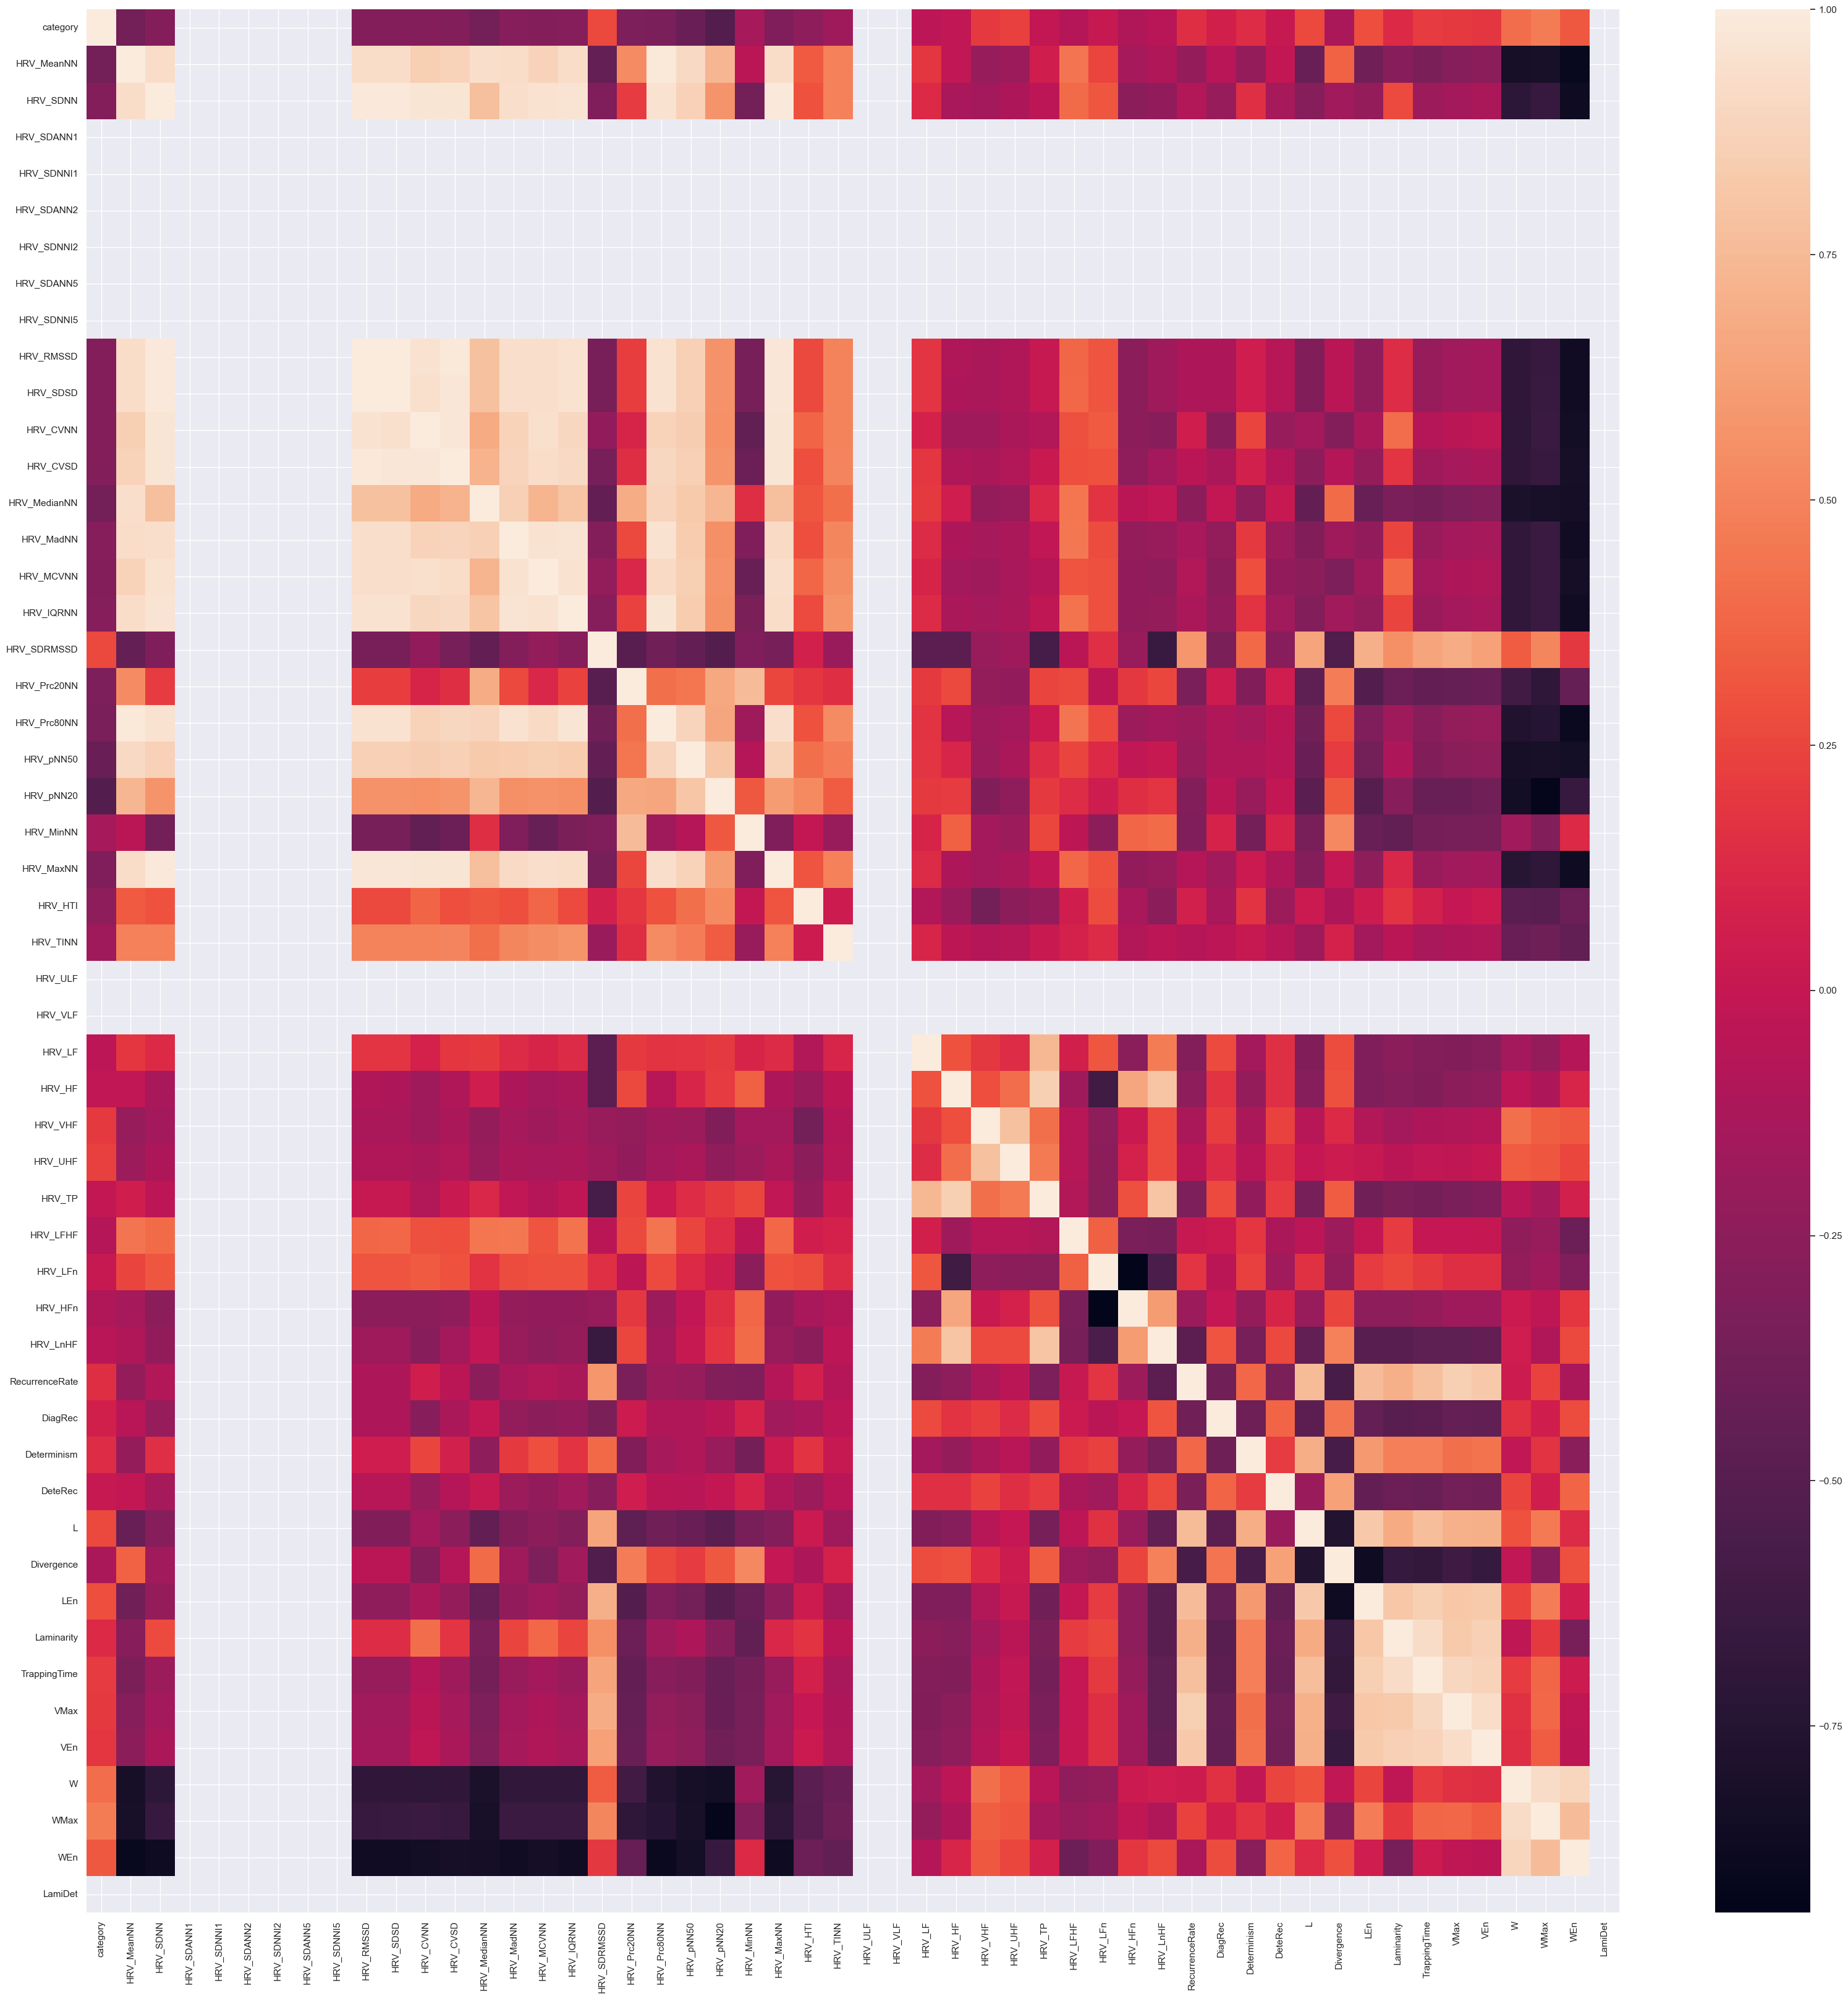

In [18]:
sns.set_theme(rc={'figure.figsize':(40,40)})
ax = sns.heatmap(
    df.drop('label', axis=1).corr(),
)